# Approach
## Steps
### 0 - Load the EEG and EMG datasets
### 1 - Preprocessing EEG and EMG data
### 2 - Rescue the ECG- EEG and ECG-EMG1, ECG-EMG2, and ECG-EMG3 with higher similarity model and weights
### 3 - Transfer learning to EEG and ECG model
### 4 - Get results

# Imports

In [1]:
# !pip install pandas pyarrow tensorflow h5py 

# !pip install numpy --upgrade --user

# !pip install tensorflow --upgrade --user

# !pip install keras --upgrade --user

# !pip install dtw-python

# !pip install scipy

# !pip install plot_keras_history

# !pip install matplotlib

# !pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from scipy import signal
import tensorflow as tf
import pyarrow as pa
import pandas as pd
import numpy as np
import scipy.fft 
import datetime
import keras
import glob
import os


from keras.layers import LSTM, Bidirectional, Dense, Dropout, Flatten, BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from plot_keras_history import show_history, plot_history
from keras.models import Sequential, model_from_json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
from keras.callbacks import Callback
from keras.utils import plot_model
from pandas import DataFrame
from pandas import concat
from pathlib import Path
from dtw import *

2023-09-17 13:08:08.910528: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-17 13:08:08.937220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 13:08:09.136989: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 13:08:09.138498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 13:08:11.140628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Variables

In [3]:
root_data_emg_path = Path(r'/media/s792288955/TOSHIBA EXT/Andrea/Kaggle/ClassifyGestures_EMG/')

scaler = MinMaxScaler(feature_range=(0, 1))
SEED = 1957
learning_rate = 0.001
n_features = 4
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

ecg_fs = 125  # frequency in Hz
ecg_lowcut = 0.5  # low frequency in Hz
ecg_highcut = 40  # hight frequency in Hz
ecg_window_length = 16
ecg_polyorder = 5

emg_fs = 200  # frequency in Hz
emg_lowcut = 0.15  # low frequency in Hz
emg_highcut = 40  # hight frequency in Hz
emg_window_length = 20
emg_polyorder = 5

# Datasets

In [4]:
# EEG

# 15 seconds
df_data_eeg_ori_v1_01_tcp_ar = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_01_tcp_ar.parquet')
df_data_eeg_ori_v1_02_tcp_le = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_02_tcp_le.parquet')
df_data_eeg_ori_v1_03_tcp_ar_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_03_tcp_ar_a.parquet')
df_data_eeg_ori_v1_04_tcp_le_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_1_0_04_tcp_le_a.parquet')

df_data_eeg_ori_v2_01_tcp_ar = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_2_0_01_tcp_ar.parquet')
df_data_eeg_ori_v2_03_tcp_ar_a = pd.read_parquet(r'/media/s792288955/TOSHIBA EXT/Andrea/Datasets/15_sec/v1_2_0_03_tcp_ar_a.parquet')

df_data_eeg_ori = pd.concat([df_data_eeg_ori_v1_01_tcp_ar, 
                             df_data_eeg_ori_v1_02_tcp_le,
                             df_data_eeg_ori_v1_03_tcp_ar_a, 
                             df_data_eeg_ori_v1_04_tcp_le_a,
                             df_data_eeg_ori_v2_01_tcp_ar, 
                             df_data_eeg_ori_v2_03_tcp_ar_a])

In [5]:
#EMG
all_emg_filenames = [i for i in root_data_emg_path.glob('*.{}'.format('csv'))]

df_data_emg_0_ori = pd.read_csv(all_emg_filenames[0], 
                                sep=",", header=None)

df_data_emg_1_ori = pd.read_csv(all_emg_filenames[1], 
                                sep=",", header=None)

df_data_emg_2_ori = pd.read_csv(all_emg_filenames[2], 
                                 sep=",", header=None)

df_data_emg_3_ori = pd.read_csv(all_emg_filenames[3], 
                                   sep=",", header=None)

df_data_emg_ori   = pd.concat([df_data_emg_0_ori,df_data_emg_1_ori,df_data_emg_2_ori,df_data_emg_3_ori], axis=0)




## Preprocessing

### EEG

In [6]:
# Split into X and Y
X_train_eeg_ori = df_data_eeg_ori[["A2", "F3", "F4", "F7", "F8", "FP1", "FP2", "FZ", 
                                   "T3", "T4", "T5", "T6", "C3", "C4", "CZ", "O1", 
                                   "O2", "P3", "P4", "PZ"]].copy()

y_train_eeg_ori = df_data_eeg_ori['id_diagnose'].copy()

print(X_train_eeg_ori.shape)
print(y_train_eeg_ori.shape)

(412400, 20)
(412400,)


In [7]:
X_train_eeg, X_test_eeg, y_train_eeg, y_test_eeg = train_test_split(X_train_eeg_ori, 
                                                                    y_train_eeg_ori, 
                                                                    train_size=0.8, random_state=None)

print(X_train_eeg.shape)
print(y_train_eeg.shape)
print(X_test_eeg.shape)
print(y_test_eeg.shape)

(329920, 20)
(329920,)
(82480, 20)
(82480,)


In [8]:
# Encode the unique values in the target
unique_train_eeg, counts_train_eeg = np.unique(y_train_eeg, return_counts = True)
print(f'Unique eeg train dependent values: {unique_train_eeg}')
print(f'counts eeg train depentent values: {counts_train_eeg}')

unique_test_eeg, counts_test_eeg = np.unique(y_test_eeg, return_counts = True)
print(f'Unique EEG test dependent values: {unique_test_eeg}')
print(f'counts EEG test depentent values: {counts_test_eeg}')

# Dictionary to map the target indices to class names
class_eeg_names = {1: 'Normal', 2: 'Abnormal', 3: 'Seizure', 10: 'Not Informed'}

# The input dims are 20
X_train_eeg_np = X_train_eeg.to_numpy()
y_train_eeg_np = y_train_eeg.to_numpy()

X_test_eeg_np = X_test_eeg.to_numpy()
y_test_eeg_np = y_test_eeg.to_numpy()

# Add a channel dimension to the input
X_train_eeg_np = X_train_eeg_np.reshape(-1, 1, 20)
y_train_eeg_np = y_train_eeg_np.reshape(-1, 1)

X_test_eeg_np = X_test_eeg_np.reshape(-1, 1, 20)
y_test_eeg_np = y_test_eeg_np.reshape(-1, 1)

print("X_train_eeg_np = ", X_train_eeg_np.shape)
print("y_train_eeg_np = ", y_train_eeg_np.shape)

print("X_test_eeg_np = ", X_test_eeg_np.shape)
print("y_test_eeg_np = ", y_test_eeg_np.shape)

Unique eeg train dependent values: [ 1  2  3 10]
counts eeg train depentent values: [ 71565 212999  36626   8730]
Unique EEG test dependent values: [ 1  2  3 10]
counts EEG test depentent values: [17667 53737  8942  2134]
X_train_eeg_np =  (329920, 1, 20)
y_train_eeg_np =  (329920, 1)
X_test_eeg_np =  (82480, 1, 20)
y_test_eeg_np =  (82480, 1)


In [9]:
# Do not need to remove noise

In [10]:
# Fourier Transforms (FFTs) to work in frequency domain.
X_train_eeg_freq  = scipy.fft.fft2(X_train_eeg_np).view(np.float64)
X_test_eeg_freq  = scipy.fft.fft2(X_test_eeg_np).view(np.float64)

In [11]:
# Normalizing the amplitude values to the range of between zero and one.
scaler_eeg = MinMaxScaler()

X_train_eeg_freq = X_train_eeg_freq.reshape(X_train_eeg_freq.shape[0], -1)
X_train_eeg_freq = scaler_eeg.fit_transform(X_train_eeg_freq)

X_test_eeg_freq = X_test_eeg_freq.reshape(X_test_eeg_freq.shape[0], -1)
X_test_eeg_freq = scaler_eeg.fit_transform(X_test_eeg_freq)

# Reshape
X_train_eeg_freq = X_train_eeg_freq.reshape(-1, 1, 40)
X_test_eeg_freq = X_test_eeg_freq.reshape(-1, 1, 40)

In [12]:
print(X_train_eeg_freq.shape)
print(y_train_eeg_np.shape)

print(X_test_eeg_freq.shape)
print(y_test_eeg_np.shape)

(329920, 1, 40)
(329920, 1)
(82480, 1, 40)
(82480, 1)


### EMG

In [13]:
# Split into X and Y
X_emg_ori = df_data_emg_ori.iloc[:,   :60].copy()
y_emg_ori = df_data_emg_ori.iloc[:,-1].copy()

print(X_emg_ori.shape)
print(y_emg_ori.shape)

(11678, 60)
(11678,)


In [14]:
# Now, train test split
X_train_emg, X_test_emg, y_train_emg, y_test_emg = train_test_split(X_emg_ori, y_emg_ori, train_size=0.8)

print(X_train_emg.shape)
print(y_train_emg.shape)
print(X_test_emg.shape)
print(y_test_emg.shape)

(9342, 60)
(9342,)
(2336, 60)
(2336,)


In [15]:
# Encode the unique values in the target
unique_train_emg, counts_train_emg = np.unique(y_train_emg, return_counts = True)
print(f'Unique EMG train dependent values: {unique_train_emg}')
print(f'counts EMG train depentent values: {counts_train_emg}')

unique_test_emg, counts_test_emg = np.unique(y_test_emg, return_counts = True)
print(f'Unique EMG test dependent values: {unique_test_emg}')
print(f'counts EMG test depentent values: {counts_test_emg}')

# Dictionary to map the target indices to class names
class_emg_names = {0: 'Rock', 1: 'Scissors', 2: 'Paper', 3: 'Ok'}

# Transform data in numpu number
X_train_emg_np = X_train_emg.to_numpy()
y_train_emg_np = y_train_emg.to_numpy()

X_test_emg_np = X_test_emg.to_numpy()
y_test_emg_np = y_test_emg.to_numpy()

# Add a channel dimension to the input
X_train_emg_np = X_train_emg_np.reshape(-1, 1, 60)
y_train_emg = y_train_emg_np.reshape(-1, 1)

X_test_emg_np = X_test_emg_np.reshape(-1, 1, 60)
y_test_emg = y_test_emg_np.reshape(-1, 1)

#Divided into 3 parts
# Add a channel dimension to the input
X_train_emg_1 = X_train_emg_np[:, :,   :20].copy()
X_train_emg_2 = X_train_emg_np[:, :, 20:40].copy()
X_train_emg_3 = X_train_emg_np[:, :, 40:60].copy()

X_test_emg_1 = X_test_emg_np[:, :,   :20].copy()
X_test_emg_2 = X_test_emg_np[:, :, 20:40].copy()
X_test_emg_3 = X_test_emg_np[:, :, 40:60].copy()

print("X_train_emg_1 = ", X_train_emg_1.shape)
print("X_train_emg_2 = ", X_train_emg_2.shape)
print("X_train_emg_3 = ", X_train_emg_3.shape)

print("X_test_emg_1 = ", X_test_emg_1.shape)
print("X_test_emg_2 = ", X_test_emg_2.shape)
print("X_test_emg_3 = ", X_test_emg_3.shape)

print("X_train_emg_ = ", y_train_emg.shape)
print("X_test_emg_ = ", y_test_emg.shape)

Unique EMG train dependent values: [0 1 2 3]
counts EMG train depentent values: [2342 2336 2359 2305]
Unique EMG test dependent values: [0 1 2 3]
counts EMG test depentent values: [568 567 584 617]
X_train_emg_1 =  (9342, 1, 20)
X_train_emg_2 =  (9342, 1, 20)
X_train_emg_3 =  (9342, 1, 20)
X_test_emg_1 =  (2336, 1, 20)
X_test_emg_2 =  (2336, 1, 20)
X_test_emg_3 =  (2336, 1, 20)
X_train_emg_ =  (9342, 1)
X_test_emg_ =  (2336, 1)


In [16]:
# EMG 1
# signal.butter - Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
emg_b, emg_a = signal.butter(4, [emg_lowcut / (emg_fs/2), emg_highcut / (emg_fs/2)], 'band')

X_train_emg_1_filtered = signal.filtfilt(emg_b, emg_a, X_train_emg_1, padlen=X_train_emg_1.shape[2]-1)
X_test_emg_1_filtered = signal.filtfilt(emg_b, emg_a, X_test_emg_1, padlen=X_test_emg_1.shape[2]-1)

# Apply moving average to remove high noise
X_train_emg_1_filtered = signal.savgol_filter(X_train_emg_1_filtered, emg_window_length, emg_polyorder)
X_test_emg_1_filtered = signal.savgol_filter(X_test_emg_1_filtered, emg_window_length, emg_polyorder)

In [17]:
# EMG 2
# signal.butter - Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
# emg_b, emg_a = signal.butter(4, [emg_lowcut / (emg_fs/2), emg_highcut / (emg_fs/2)], 'band')
X_train_emg_2_filtered = signal.filtfilt(emg_b, emg_a, X_train_emg_2, padlen=X_train_emg_2.shape[2]-1)
X_test_emg_2_filtered = signal.filtfilt(emg_b, emg_a, X_test_emg_2, padlen=X_test_emg_2.shape[2]-1)

# Apply moving average to remove high noise
X_train_emg_2_filtered = signal.savgol_filter(X_train_emg_2_filtered, emg_window_length, emg_polyorder)
X_test_emg_2_filtered = signal.savgol_filter(X_test_emg_2_filtered, emg_window_length, emg_polyorder)

In [18]:
# EMG 3
# signal.butter - Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.
# emg_b, emg_a = signal.butter(4, [emg_lowcut / (emg_fs/2), emg_highcut / (emg_fs/2)], 'band')
X_train_emg_3_filtered = signal.filtfilt(emg_b, emg_a, X_train_emg_3, padlen=X_train_emg_1.shape[2]-1)
X_test_emg_3_filtered = signal.filtfilt(emg_b, emg_a, X_test_emg_3, padlen=X_test_emg_1.shape[2]-1)

# Apply moving average to remove high noise
X_train_emg_3_filtered = signal.savgol_filter(X_train_emg_3_filtered, emg_window_length, emg_polyorder)
X_test_emg_3_filtered = signal.savgol_filter(X_test_emg_3_filtered, emg_window_length, emg_polyorder)

In [19]:
print(X_train_emg_1_filtered.shape)
print(X_test_emg_1_filtered.shape)

(9342, 1, 20)
(2336, 1, 20)


In [20]:
# Fourier Transforms (FFTs) to work in frequency domain.
X_train_emg_1_freq  = scipy.fft.fft2(X_train_emg_1_filtered).view(np.float64)
X_test_emg_1_freq  = scipy.fft.fft2(X_test_emg_1_filtered).view(np.float64)

X_train_emg_2_freq  = scipy.fft.fft2(X_train_emg_2_filtered).view(np.float64)
X_test_emg_2_freq  = scipy.fft.fft2(X_test_emg_2_filtered).view(np.float64)

X_train_emg_3_freq  = scipy.fft.fft2(X_train_emg_3_filtered).view(np.float64)
X_test_emg_3_freq  = scipy.fft.fft2(X_test_emg_3_filtered).view(np.float64)


In [21]:
print(X_train_emg_1_freq.shape)
print(X_test_emg_1_freq.shape)

print(X_train_emg_2_freq.shape)
print(X_test_emg_2_freq.shape)

print(X_train_emg_3_freq.shape)
print(X_test_emg_3_freq.shape)

print(y_train_emg.shape)
print(y_test_emg.shape)

(9342, 1, 40)
(2336, 1, 40)
(9342, 1, 40)
(2336, 1, 40)
(9342, 1, 40)
(2336, 1, 40)
(9342, 1)
(2336, 1)


# Tranfer learning

In [22]:
epochs_eeg = 20

In [23]:
#Load json ECG G9 epoch model 
json_file = open("./model_weights/model_bl_lstm_ecg_g9_20features_" + str(epochs_eeg) + "epochs_FINAL.json", "r") 
loaded_model_ecg_lstm_json = json_file.read()
json_file.close()


### ECG to EEG

In [24]:
#Load saved weights to loaded ecg model
model_lstm_eeg = model_from_json(loaded_model_ecg_lstm_json)
model_lstm_eeg.load_weights("./model_weights/model_bl_lstm_weights_ecg_g9_20features_" + 
                            str(epochs_eeg) + "epochs_FINAL.h5")


In [25]:
model_lstm_eeg.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 1, 80)             25920     
 onal)                                                           
                                                                 
 lstm_37 (LSTM)              (None, 1, 256)            345088    
                                                                 
 dropout_24 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_38 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_25 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_39 (LSTM)              (None, 1, 64)             49408     
                                                      

In [26]:
model_lstm_eeg.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                       loss="mean_squared_error",
                       metrics=["accuracy", 
                                tf.keras.metrics.MeanSquaredError(), 
                                tf.keras.metrics.RootMeanSquaredError(),
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall(),
                                tf.keras.metrics.PrecisionAtRecall(0.5)])

In [27]:
# Train - (329920, 1, 40) / Teste -(82480, 1, 40)

eeg_train_batch_size = 33000 
eeg_test_batch_size = 9000

In [28]:
#Evaluating without Retrain

score_evaluate_eeg = model_lstm_eeg.evaluate(x = X_train_eeg_freq, 
                                             y = y_train_eeg, 
                                             batch_size = eeg_train_batch_size,   
                                             verbose = 1)

print("TL's ECG to EEG Evaluate Result without Retrain")

print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[0].upper(), score_evaluate_eeg[0]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[1].upper(), score_evaluate_eeg[1]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[2].upper(), score_evaluate_eeg[2]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[3].upper(), score_evaluate_eeg[3]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[4].upper(), score_evaluate_eeg[4]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[5].upper(), score_evaluate_eeg[5]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[6].upper(), score_evaluate_eeg[6]*100))

10/10 [==============================] - 5s 280ms/step - loss: 4.8326 - accuracy: 0.0000e+00 - mean_squared_error: 4.8326 - root_mean_squared_error: 2.1983 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 1.0000
TL's ECG to EEG Evaluate Result without Retrain
Evaluate without Retrain LOSS: 483.2579%
Evaluate without Retrain ACCURACY: 0.0000%
Evaluate without Retrain MEAN_SQUARED_ERROR: 483.2579%
Evaluate without Retrain ROOT_MEAN_SQUARED_ERROR: 219.8313%
Evaluate without Retrain PRECISION: 0.0000%
Evaluate without Retrain RECALL: 0.0000%
Evaluate without Retrain PRECISION_AT_RECALL: 100.0000%


In [29]:
score_evaluate_test_eeg = model_lstm_eeg.evaluate(x = X_test_eeg_freq, 
                                                  y = y_test_eeg, 
                                                  batch_size = eeg_test_batch_size, 
                                                  verbose = 1)

print("TL's ECG to EEG Evaluate Test Result without Retrain")
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[0].upper(), score_evaluate_test_eeg[0]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[1].upper(), score_evaluate_test_eeg[1]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[2].upper(), score_evaluate_test_eeg[2]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[3].upper(), score_evaluate_test_eeg[3]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[4].upper(), score_evaluate_test_eeg[4]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[5].upper(), score_evaluate_test_eeg[5]*100))
print("Test %s: %.4f%%" % (model_lstm_eeg.metrics_names[6].upper(), score_evaluate_test_eeg[6]*100))

10/10 [==============================] - 1s 74ms/step - loss: 4.7784 - accuracy: 0.0000e+00 - mean_squared_error: 4.7784 - root_mean_squared_error: 2.1860 - precision: 0.0000e+00 - recall: 0.0000e+00 - precision_at_recall: 1.0000
TL's ECG to EEG Evaluate Test Result without Retrain
Test LOSS: 477.8450%
Test ACCURACY: 0.0000%
Test MEAN_SQUARED_ERROR: 477.8450%
Test ROOT_MEAN_SQUARED_ERROR: 218.5966%
Test PRECISION: 0.0000%
Test RECALL: 0.0000%
Test PRECISION_AT_RECALL: 100.0000%


In [297]:
epochs_eeg_retrain = 400

In [298]:
#Train EEG Model to calibrate the parameters

# suffle = False - dont allow mix the data 
history_eeg = model_lstm_eeg.fit(X_train_eeg_freq, 
                                 y_train_eeg, 
                                 validation_split=0.2, 
                                 epochs=epochs_eeg_retrain, 
                                 batch_size=eeg_train_batch_size, 
                                 shuffle=True)

Epoch 1/400
8/8 [==============================] - 7s 883ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 2/400
8/8 [==============================] - 7s 858ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 3/400
8/8 [==============================] - 7s 956ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7

Epoch 21/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 22/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 23/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - 

Epoch 41/400
8/8 [==============================] - 8s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 42/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 43/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - 

Epoch 61/400
8/8 [==============================] - 8s 987ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 62/400
8/8 [==============================] - 8s 998ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 63/400
8/8 [==============================] - 8s 985ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 

Epoch 100/400
8/8 [==============================] - 9s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 101/400
8/8 [==============================] - 8s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 102/400
8/8 [==============================] - 8s 1s/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983

8/8 [==============================] - 7s 927ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 139/400
8/8 [==============================] - 8s 953ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 140/400
8/8 [==============================] - 7s 929ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 7s 942ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 177/400
8/8 [==============================] - 7s 926ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 178/400
8/8 [==============================] - 7s 943ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 7s 926ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 215/400
8/8 [==============================] - 7s 943ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 216/400
8/8 [==============================] - 7s 941ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 8s 947ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 253/400
8/8 [==============================] - 7s 923ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 254/400
8/8 [==============================] - 7s 949ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 7s 919ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 291/400
8/8 [==============================] - 7s 939ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 292/400
8/8 [==============================] - 7s 922ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 7s 923ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 329/400
8/8 [==============================] - 7s 926ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 330/400
8/8 [==============================] - 7s 942ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

8/8 [==============================] - 7s 929ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 367/400
8/8 [==============================] - 7s 936ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000 - val_loss: 3.2292 - val_accuracy: 0.2195 - val_mean_squared_error: 3.2292 - val_root_mean_squared_error: 1.7970 - val_precision: 1.0000 - val_recall: 1.0000 - val_precision_at_recall: 1.0000
Epoch 368/400
8/8 [==============================] - 7s 914ms/step - loss: 3.2340 - accuracy: 0.2163 - mean_squared_error: 3.2340 - root_mean_squared_error: 1.7983 - pr

dict_keys(['loss', 'accuracy', 'mean_squared_error', 'root_mean_squared_error', 'precision', 'recall', 'precision_at_recall', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_precision', 'val_recall', 'val_precision_at_recall'])


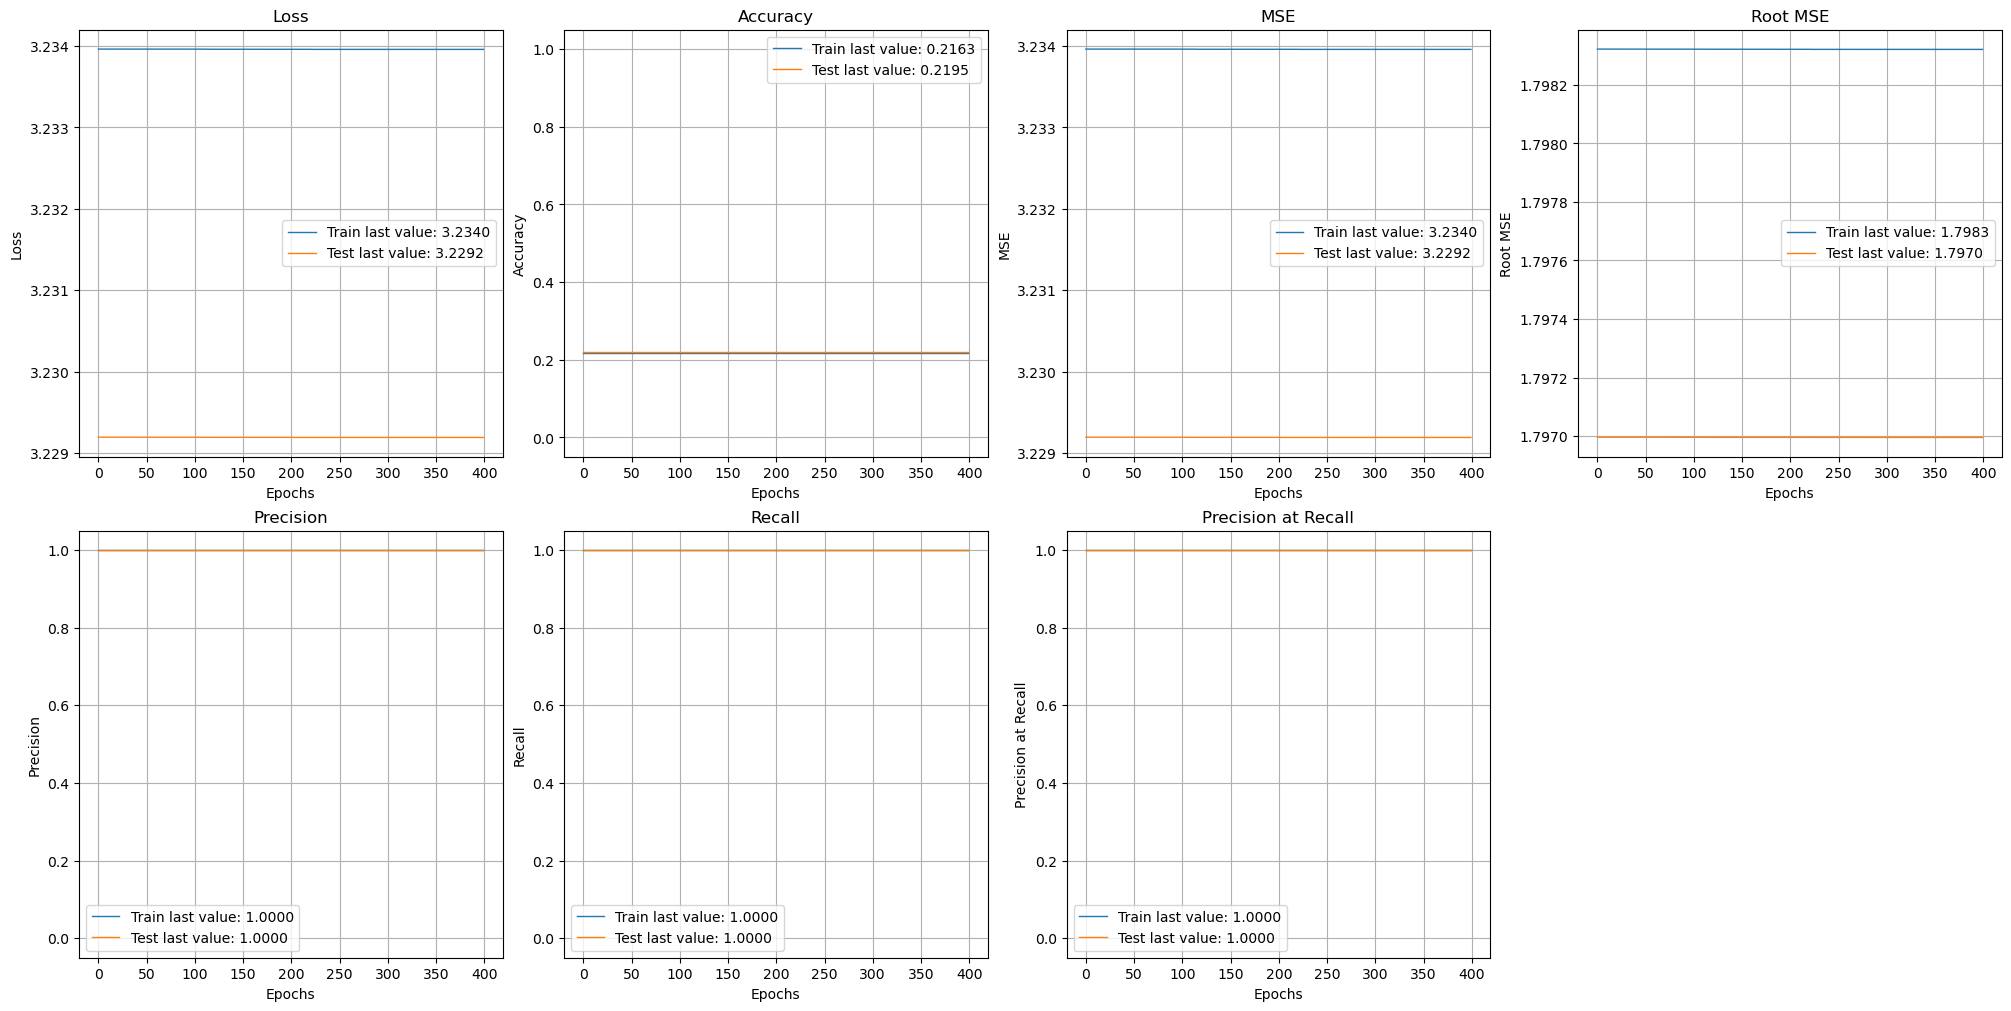

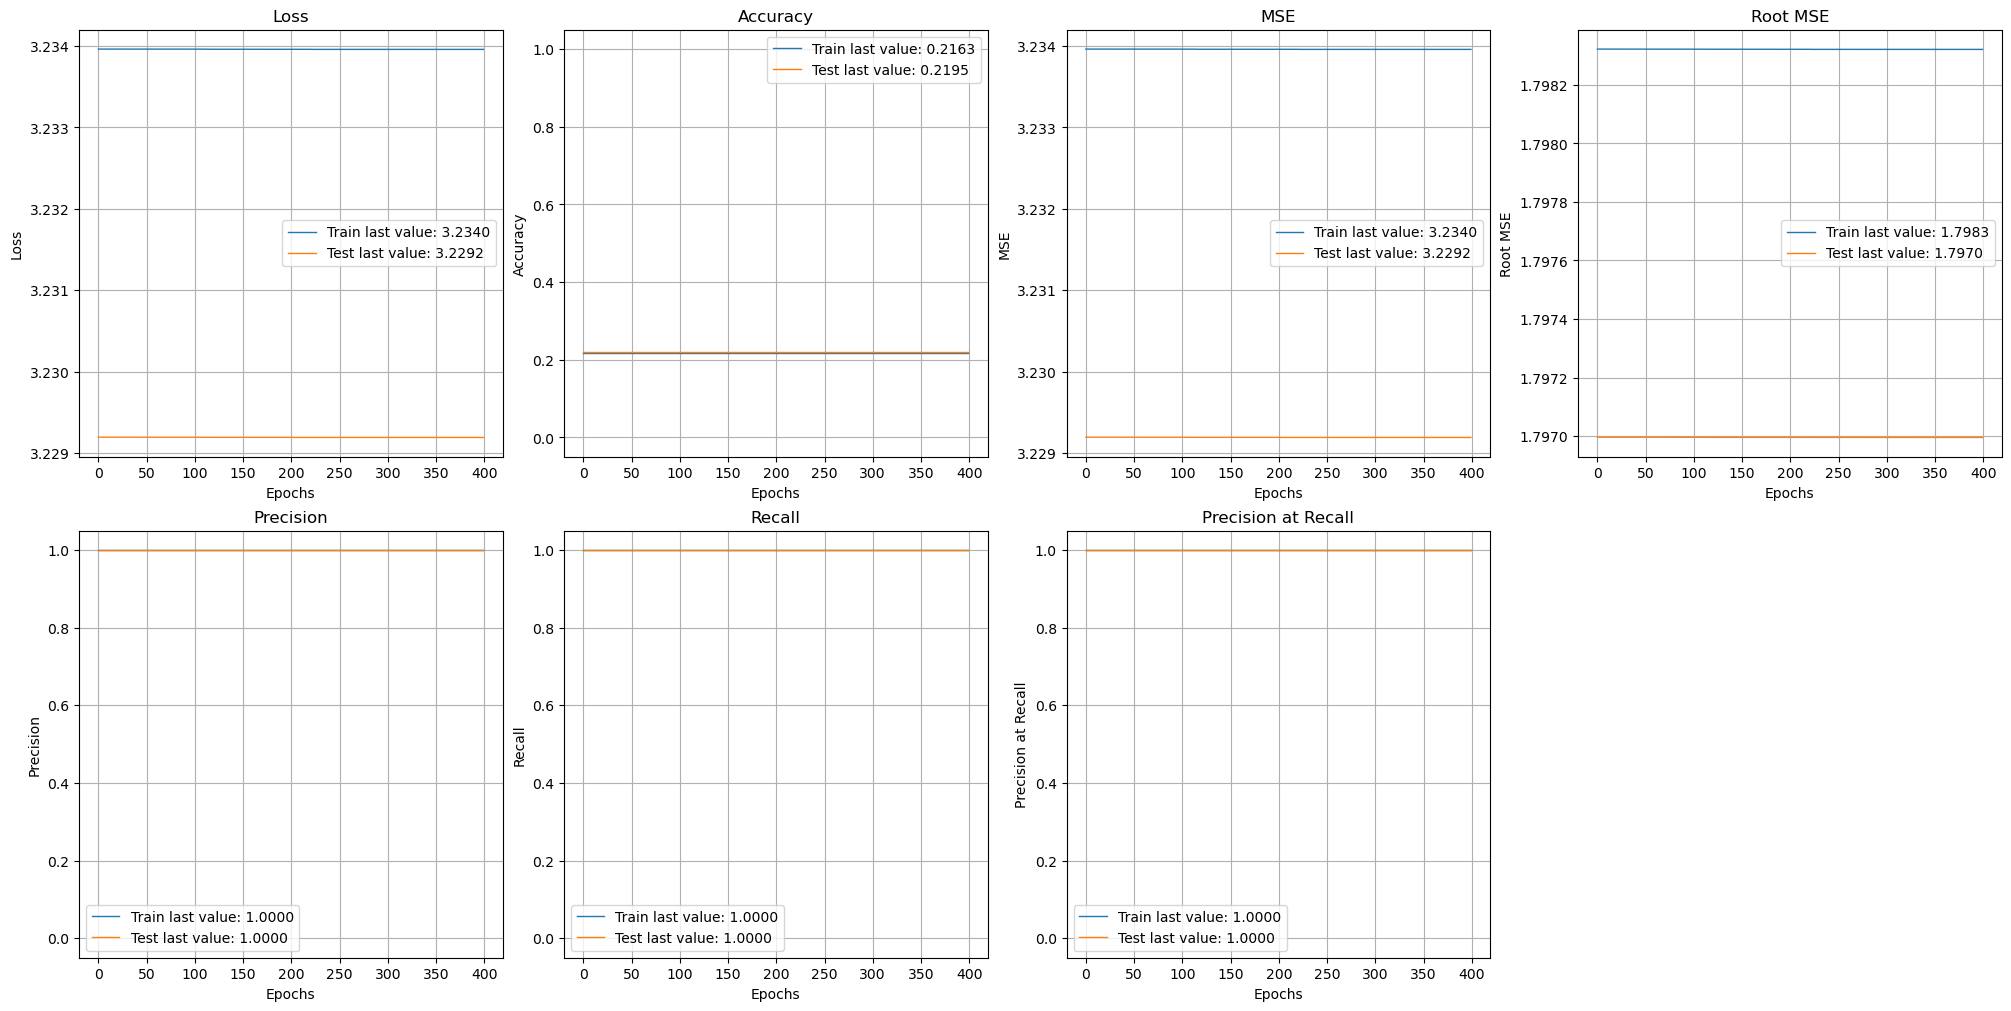

In [299]:
# list all data in history
print(history_eeg.history.keys())

path_his_eeg = "History_EEG_Retrain_" + str(epochs_eeg_retrain) + "epochs_FINAL"

# summarize history for accuracy
show_history(history_eeg)
plot_history(history_eeg)
plot_history(history_eeg, path=path_his_eeg)
plt.close()

In [300]:
score_retrain_eeg = model_lstm_eeg.evaluate(x = X_train_eeg_freq, 
                                             y = y_train_eeg, 
                                             batch_size = eeg_train_batch_size, 
                                             verbose = 1)

print("EEG Retrain Signal")

print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[0].upper(), score_retrain_eeg[0]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[1].upper(), score_retrain_eeg[1]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[2].upper(), score_retrain_eeg[2]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[3].upper(), score_retrain_eeg[3]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[4].upper(), score_retrain_eeg[4]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[5].upper(), score_retrain_eeg[5]*100))
print("Retrain %s: %.4f%%" % (model_lstm_eeg.metrics_names[6].upper(), score_retrain_eeg[6]*100))


10/10 [==============================] - 3s 316ms/step - loss: 3.2330 - accuracy: 0.2169 - mean_squared_error: 3.2330 - root_mean_squared_error: 1.7981 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000
EEG Retrain Signal
Retrain LOSS: 323.3005%
Retrain ACCURACY: 21.6916%
Retrain MEAN_SQUARED_ERROR: 323.3005%
Retrain ROOT_MEAN_SQUARED_ERROR: 179.8056%
Retrain PRECISION: 100.0000%
Retrain RECALL: 100.0000%
Retrain PRECISION_AT_RECALL: 100.0000%


In [301]:
score_retest_eeg = model_lstm_eeg.evaluate(x = X_test_eeg_freq, 
                                           y = y_test_eeg, 
                                           batch_size = eeg_test_batch_size, 
                                           verbose = 1)

print("EEG Retest Signal")
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[0].upper(), score_retest_eeg[0]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[1].upper(), score_retest_eeg[1]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[2].upper(), score_retest_eeg[2]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[3].upper(), score_retest_eeg[3]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[4].upper(), score_retest_eeg[4]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[5].upper(), score_retest_eeg[5]*100))
print("Retest %s: %.4f%%" % (model_lstm_eeg.metrics_names[6].upper(), score_retest_eeg[6]*100))


10/10 [==============================] - 1s 78ms/step - loss: 3.1809 - accuracy: 0.2142 - mean_squared_error: 3.1809 - root_mean_squared_error: 1.7835 - precision: 1.0000 - recall: 1.0000 - precision_at_recall: 1.0000
EEG Retest Signal
Retest LOSS: 318.0881%
Retest ACCURACY: 21.4197%
Retest MEAN_SQUARED_ERROR: 318.0881%
Retest ROOT_MEAN_SQUARED_ERROR: 178.3502%
Retest PRECISION: 100.0000%
Retest RECALL: 100.0000%
Retest PRECISION_AT_RECALL: 100.0000%


### ECG to EMG

In [65]:
# Train - (9342, 1, 128) / Teste - (2336, 1, 128)

emg_train_batch_size = 900
emg_test_batch_size = 300

#### EMG1

In [264]:
epochs_emg_1 = 400
epochs_emg_retrain = 20

In [265]:
#Load json ECG G1 epoch model                  
json_file = open("./model_weights/model_bl_lstm_ecg_g1_20features_" + str(epochs_emg_1) + 
                 "epochs_FINAL.json", "r") 
loaded_model_ecg_lstm_json = json_file.read()
json_file.close()

In [266]:
#Load saved weights to loaded ecg model
model_lstm_emg_1 = model_from_json(loaded_model_ecg_lstm_json)
model_lstm_emg_1.load_weights("./model_weights/model_bl_lstm_weights_ecg_g1_20features_" + 
                            str(epochs_emg_1) + "epochs_FINAL.h5")

In [267]:
model_lstm_emg_1.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_83 (Bidirect  (None, 1, 80)             25920     
 ional)                                                          
                                                                 
 lstm_196 (LSTM)             (None, 1, 256)            345088    
                                                                 
 dropout_90 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_197 (LSTM)             (None, 1, 128)            197120    
                                                                 
 dropout_91 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_198 (LSTM)             (None, 1, 64)             49408     
                                                     

In [268]:
model_lstm_emg_1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                                 loss="mean_squared_error",
                                 metrics=["accuracy", 
                                          tf.keras.metrics.MeanSquaredError(), 
                                          tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          tf.keras.metrics.PrecisionAtRecall(0.5)])

In [269]:
#Evaluating without Retrain

score_evaluate_emg_1 = model_lstm_emg_1.evaluate(x = X_train_emg_1_freq, 
                                             y = y_train_emg, 
                                             batch_size = emg_train_batch_size, 
                                             verbose = 1)

print("TL's ECG to EMG Evaluate Result without Retrain")

print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[0].upper(), score_evaluate_emg_1[0]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[1].upper(), score_evaluate_emg_1[1]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[2].upper(), score_evaluate_emg_1[2]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[3].upper(), score_evaluate_emg_1[3]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[4].upper(), score_evaluate_emg_1[4]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[5].upper(), score_evaluate_emg_1[5]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[6].upper(), score_evaluate_emg_1[6]*100))

11/11 [==============================] - 2s 10ms/step - loss: 2.5758 - accuracy: 0.2592 - mean_squared_error: 2.5758 - root_mean_squared_error: 1.6049 - precision_19: 0.7689 - recall_19: 0.3650 - precision_at_recall_19: 0.7552
TL's ECG to EMG Evaluate Result without Retrain
Evaluate without Retrain LOSS: 257.5803%
Evaluate without Retrain ACCURACY: 25.9152%
Evaluate without Retrain MEAN_SQUARED_ERROR: 257.5803%
Evaluate without Retrain ROOT_MEAN_SQUARED_ERROR: 160.4931%
Evaluate without Retrain PRECISION_19: 76.8884%
Evaluate without Retrain RECALL_19: 36.5000%
Evaluate without Retrain PRECISION_AT_RECALL_19: 75.5168%


In [270]:
score_evaluate_test_emg_1 = model_lstm_emg_1.evaluate(x = X_test_emg_1_freq, 
                                                  y = y_test_emg, 
                                                  batch_size = emg_test_batch_size, 
                                                  verbose = 1)

print("TL's ECG to EMG Evaluate Test Result without Retrain")
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[0].upper(), score_evaluate_test_emg_1[0]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[1].upper(), score_evaluate_test_emg_1[1]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[2].upper(), score_evaluate_test_emg_1[2]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[3].upper(), score_evaluate_test_emg_1[3]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[4].upper(), score_evaluate_test_emg_1[4]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[5].upper(), score_evaluate_test_emg_1[5]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_1.metrics_names[6].upper(), score_evaluate_test_emg_1[6]*100))

8/8 [==============================] - 0s 6ms/step - loss: 2.6436 - accuracy: 0.2611 - mean_squared_error: 2.6436 - root_mean_squared_error: 1.6259 - precision_19: 0.7881 - recall_19: 0.3807 - precision_at_recall_19: 0.7758
TL's ECG to EMG Evaluate Test Result without Retrain
Test LOSS: 264.3588%
Test ACCURACY: 26.1130%
Test MEAN_SQUARED_ERROR: 264.3588%
Test ROOT_MEAN_SQUARED_ERROR: 162.5911%
Test PRECISION_19: 78.8056%
Test RECALL_19: 38.0656%
Test PRECISION_AT_RECALL_19: 77.5777%


In [271]:
#Train ECG Model to calibrate the parameters
# suffle = False - dont allow mix the data 
history_emg_1 = model_lstm_emg_1.fit(X_train_emg_1_freq, 
                                 y_train_emg, 
                                 validation_split=0.2, 
                                 epochs=epochs_emg_retrain, 
                                 batch_size=emg_train_batch_size, 
                                 shuffle=False)

Epoch 1/20
9/9 [==============================] - 7s 35ms/step - loss: 2.4451 - accuracy: 0.2541 - mean_squared_error: 2.4451 - root_mean_squared_error: 1.5637 - precision_19: 0.7631 - recall_19: 0.4146 - precision_at_recall_19: 0.7577 - val_loss: 2.2146 - val_accuracy: 0.2638 - val_mean_squared_error: 2.2146 - val_root_mean_squared_error: 1.4882 - val_precision_19: 0.7435 - val_recall_19: 0.5033 - val_precision_at_recall_19: 0.7443
Epoch 2/20
9/9 [==============================] - 0s 31ms/step - loss: 1.9987 - accuracy: 0.2431 - mean_squared_error: 1.9987 - root_mean_squared_error: 1.4138 - precision_19: 0.7548 - recall_19: 0.6313 - precision_at_recall_19: 0.7624 - val_loss: 1.7176 - val_accuracy: 0.2236 - val_mean_squared_error: 1.7176 - val_root_mean_squared_error: 1.3106 - val_precision_19: 0.7229 - val_recall_19: 0.8447 - val_precision_at_recall_19: 0.7380
Epoch 3/20
9/9 [==============================] - 0s 30ms/step - loss: 1.5677 - accuracy: 0.2497 - mean_squared_error: 1.5677 

Epoch 20/20
9/9 [==============================] - 0s 30ms/step - loss: 1.4819 - accuracy: 0.2555 - mean_squared_error: 1.4819 - root_mean_squared_error: 1.2173 - precision_19: 0.7555 - recall_19: 0.9998 - precision_at_recall_19: 0.7623 - val_loss: 1.5201 - val_accuracy: 0.2317 - val_mean_squared_error: 1.5201 - val_root_mean_squared_error: 1.2329 - val_precision_19: 0.7271 - val_recall_19: 1.0000 - val_precision_at_recall_19: 0.7296


dict_keys(['loss', 'accuracy', 'mean_squared_error', 'root_mean_squared_error', 'precision_19', 'recall_19', 'precision_at_recall_19', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_precision_19', 'val_recall_19', 'val_precision_at_recall_19'])


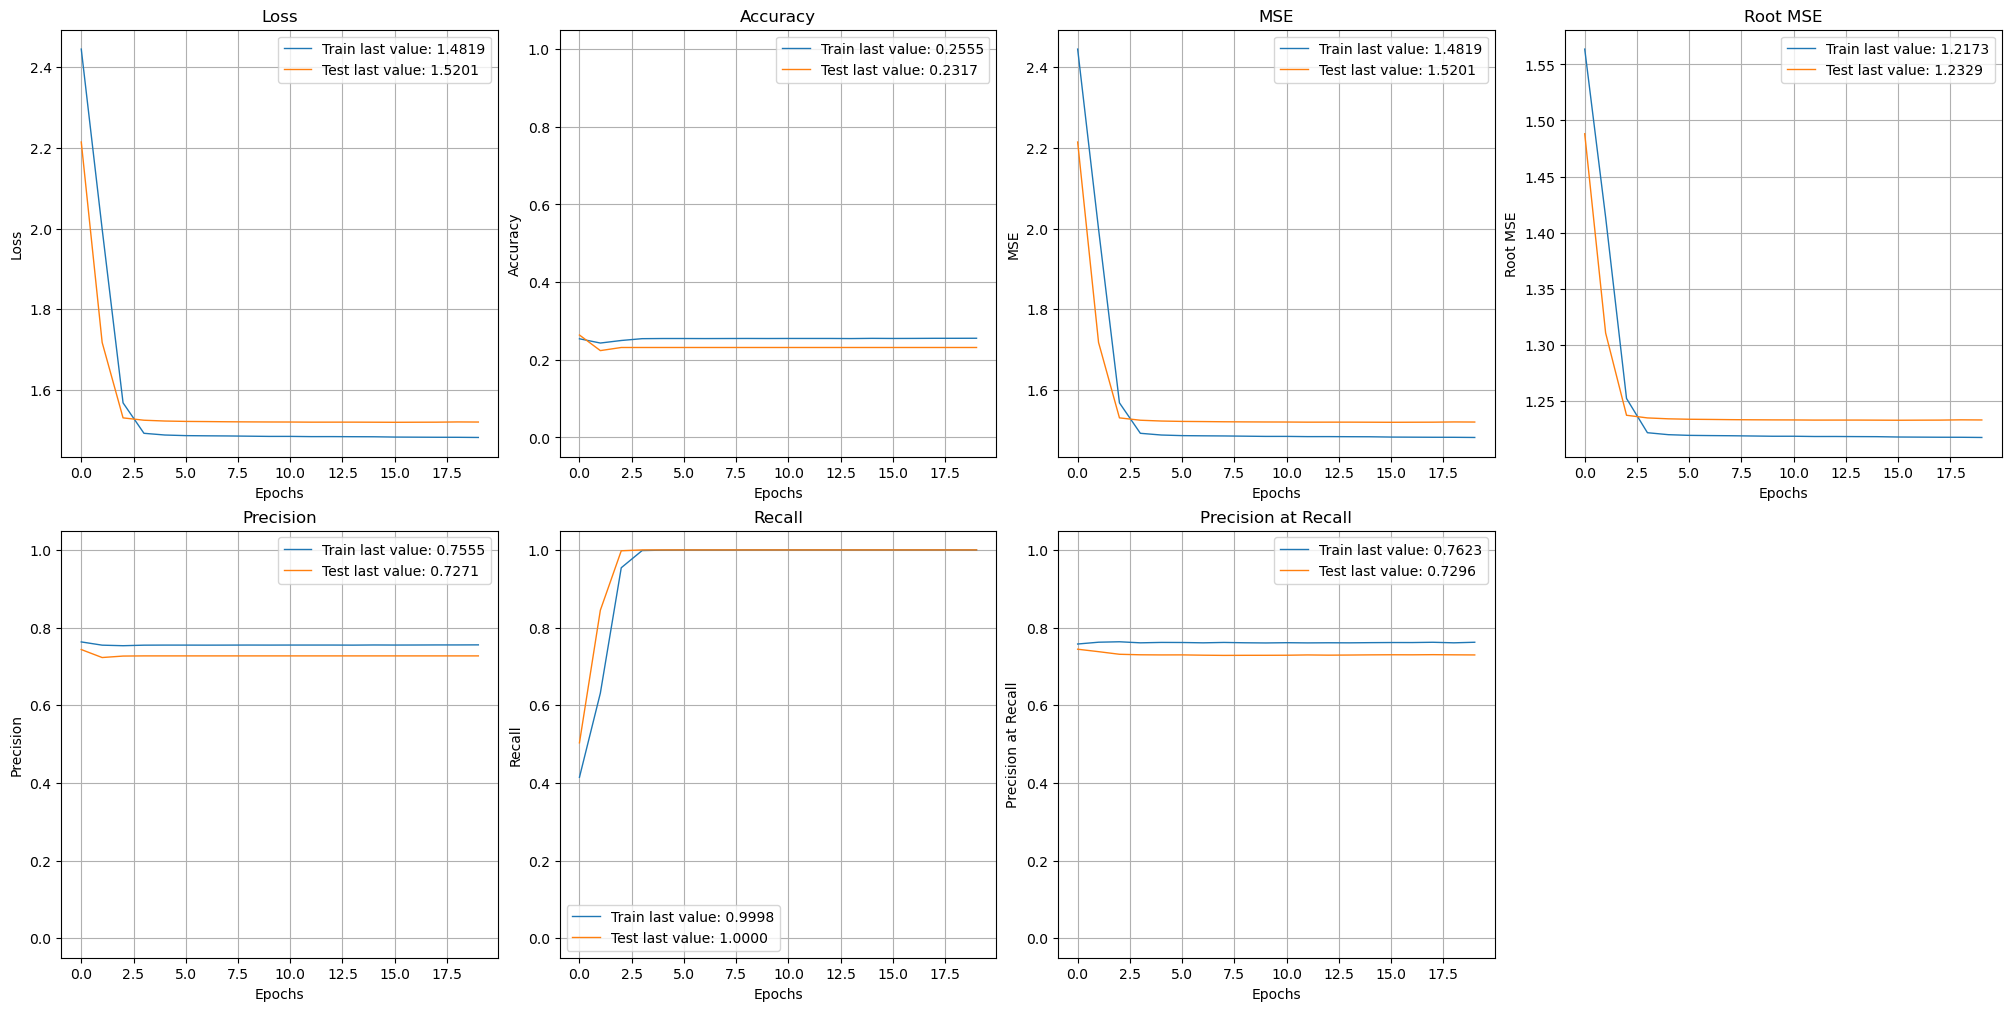

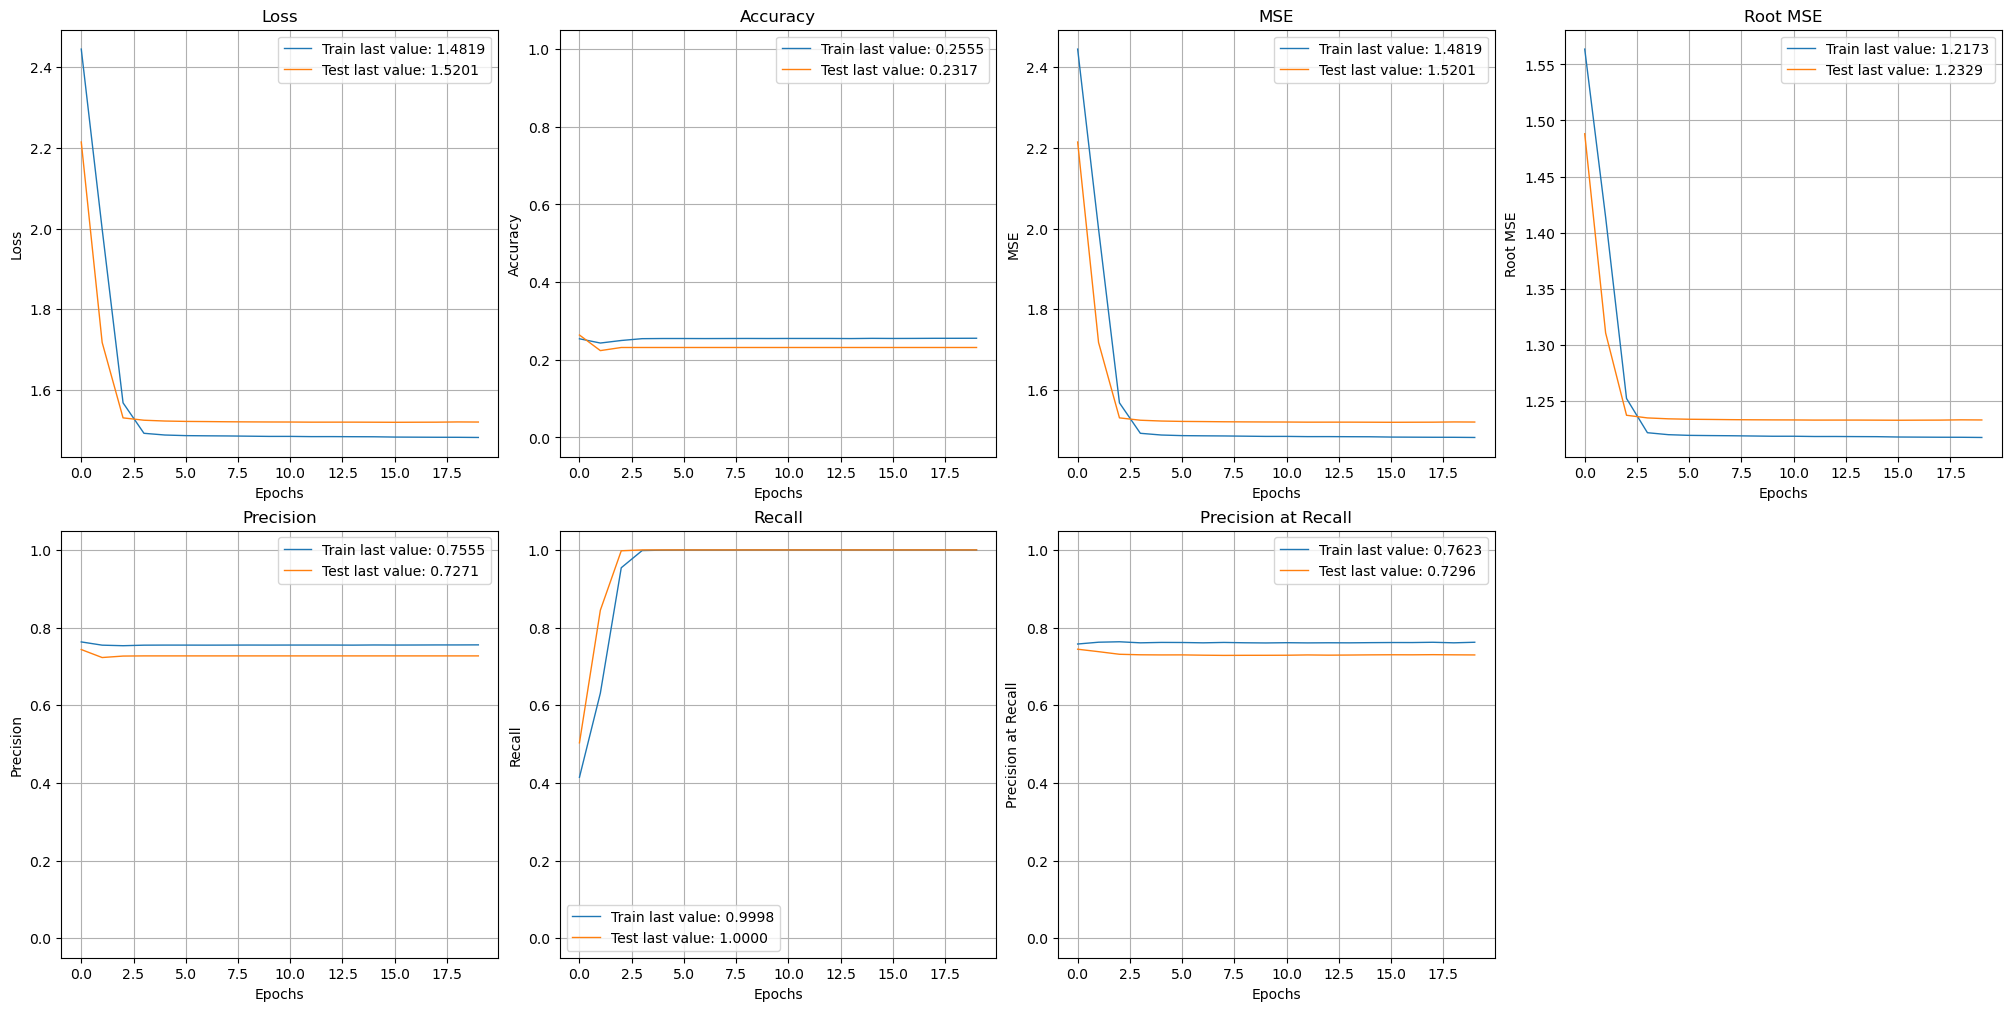

In [272]:
# list all data in history
print(history_emg_1.history.keys())

path_his_emg = "History_EMG_1_Retrain_" + str(epochs_emg_retrain) + "epochs_FINAL.png"

# summarize history for accuracy
show_history(history_emg_1)
plot_history(history_emg_1)
plot_history(history_emg_1, path=path_his_emg)
plt.close()

In [273]:
#Evaluate's EMG model for train dataset

score_retrain_emg_1 = model_lstm_emg_1.evaluate(x = X_train_emg_1_freq, 
                                            y = y_train_emg, 
                                            batch_size = emg_train_batch_size, 
                                            verbose = 1)

print("EMG Retrain Signal")
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[0].upper(), score_retrain_emg_1[0]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[1].upper(), score_retrain_emg_1[1]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[2].upper(), score_retrain_emg_1[2]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[3].upper(), score_retrain_emg_1[3]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[4].upper(), score_retrain_emg_1[4]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[5].upper(), score_retrain_emg_1[5]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_1.metrics_names[6].upper(), score_retrain_emg_1[6]*100))

11/11 [==============================] - 0s 12ms/step - loss: 1.4890 - accuracy: 0.2510 - mean_squared_error: 1.4890 - root_mean_squared_error: 1.2202 - precision_19: 0.7500 - recall_19: 1.0000 - precision_at_recall_19: 0.7551
EMG Retrain Signal
Retrain LOSS: 148.8985%
Retrain ACCURACY: 25.1017%
Retrain MEAN_SQUARED_ERROR: 148.8985%
Retrain ROOT_MEAN_SQUARED_ERROR: 122.0240%
Retrain PRECISION_19: 75.0027%
Retrain RECALL_19: 100.0000%
Retrain PRECISION_AT_RECALL_19: 75.5109%


In [274]:
# Evaluate's EMG model for test dataset

score_retest_emg_1 = model_lstm_emg_1.evaluate(x = X_test_emg_1_freq, 
                                           y = y_test_emg, 
                                           batch_size = emg_test_batch_size, 
                                           verbose = 1)

print("EMG Retest Signal")
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[0].upper(), score_retest_emg_1[0]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[1].upper(), score_retest_emg_1[1]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[2].upper(), score_retest_emg_1[2]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[3].upper(), score_retest_emg_1[3]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[4].upper(), score_retest_emg_1[4]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[5].upper(), score_retest_emg_1[5]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_1.metrics_names[6].upper(), score_retest_emg_1[6]*100))

8/8 [==============================] - 0s 6ms/step - loss: 1.5527 - accuracy: 0.2427 - mean_squared_error: 1.5527 - root_mean_squared_error: 1.2461 - precision_19: 0.7567 - recall_19: 0.9994 - precision_at_recall_19: 0.7604
EMG Retest Signal
Retest LOSS: 155.2656%
Retest ACCURACY: 24.2723%
Retest MEAN_SQUARED_ERROR: 155.2656%
Retest ROOT_MEAN_SQUARED_ERROR: 124.6056%
Retest PRECISION_19: 75.6745%
Retest RECALL_19: 99.9434%
Retest PRECISION_AT_RECALL_19: 76.0389%


#### EMG2

In [275]:
epochs_emg_2 = 20

In [276]:
#Load json ECG G1 epoch model 
json_file = open("./model_weights/model_bl_lstm_ecg_g2_20features_" 
                 + str(epochs_emg_2) + "epochs_FINAL.json", "r") 
loaded_model_ecg_lstm_json = json_file.read()
json_file.close()

In [277]:
#Load saved weights to loaded ecg model
model_lstm_emg_2 = model_from_json(loaded_model_ecg_lstm_json)
model_lstm_emg_2.load_weights("./model_weights/model_bl_lstm_weights_ecg_g2_20features_" + 
                            str(epochs_emg_1) + "epochs_FINAL.h5")

In [278]:
model_lstm_emg_2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_56 (Bidirect  (None, 1, 80)             25920     
 ional)                                                          
                                                                 
 lstm_127 (LSTM)             (None, 1, 256)            345088    
                                                                 
 dropout_42 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_128 (LSTM)             (None, 1, 128)            197120    
                                                                 
 dropout_43 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_129 (LSTM)             (None, 1, 64)             49408     
                                                     

In [279]:
model_lstm_emg_2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                                 loss="mean_squared_error",
                                 metrics=["accuracy", 
                                          tf.keras.metrics.MeanSquaredError(), 
                                          tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          tf.keras.metrics.PrecisionAtRecall(0.5)])

In [280]:
#Evaluating without Retrain

score_evaluate_emg_2 = model_lstm_emg_2.evaluate(x = X_train_emg_2_freq, 
                                             y = y_train_emg, 
                                             batch_size = emg_train_batch_size, 
                                             verbose = 2)

print("TL's ECG to EMG Evaluate Result without Retrain")

print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[0].upper(), score_evaluate_emg_2[0]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[1].upper(), score_evaluate_emg_2[1]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[2].upper(), score_evaluate_emg_2[2]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[3].upper(), score_evaluate_emg_2[3]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[4].upper(), score_evaluate_emg_2[4]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[5].upper(), score_evaluate_emg_2[5]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[6].upper(), score_evaluate_emg_2[6]*100))

11/11 - 2s - loss: 2.3623 - accuracy: 0.2582 - mean_squared_error: 2.3623 - root_mean_squared_error: 1.5370 - precision_20: 0.8477 - recall_20: 0.0533 - precision_at_recall_20: 0.7493 - 2s/epoch - 218ms/step
TL's ECG to EMG Evaluate Result without Retrain
Evaluate without Retrain LOSS: 236.2278%
Evaluate without Retrain ACCURACY: 25.8189%
Evaluate without Retrain MEAN_SQUARED_ERROR: 236.2278%
Evaluate without Retrain ROOT_MEAN_SQUARED_ERROR: 153.6970%
Evaluate without Retrain PRECISION_20: 84.7727%
Evaluate without Retrain RECALL_20: 5.3286%
Evaluate without Retrain PRECISION_AT_RECALL_20: 74.9304%


In [281]:
score_evaluate_test_emg_2 = model_lstm_emg_2.evaluate(x = X_test_emg_2_freq, 
                                                  y = y_test_emg, 
                                                  batch_size = emg_test_batch_size, 
                                                  verbose = 2)

print("TL's ECG to EMG Evaluate Test Result without Retrain")
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[0].upper(), score_evaluate_test_emg_2[0]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[1].upper(), score_evaluate_test_emg_2[1]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[2].upper(), score_evaluate_test_emg_2[2]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[3].upper(), score_evaluate_test_emg_2[3]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[4].upper(), score_evaluate_test_emg_2[4]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[5].upper(), score_evaluate_test_emg_2[5]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_2.metrics_names[6].upper(), score_evaluate_test_emg_2[6]*100))

8/8 - 0s - loss: 2.4710 - accuracy: 0.2513 - mean_squared_error: 2.4710 - root_mean_squared_error: 1.5719 - precision_20: 0.8333 - recall_20: 0.0481 - precision_at_recall_20: 0.7568 - 60ms/epoch - 7ms/step
TL's ECG to EMG Evaluate Test Result without Retrain
Test LOSS: 247.1012%
Test ACCURACY: 25.1284%
Test MEAN_SQUARED_ERROR: 247.1012%
Test ROOT_MEAN_SQUARED_ERROR: 157.1945%
Test PRECISION_20: 83.3333%
Test RECALL_20: 4.8077%
Test PRECISION_AT_RECALL_20: 75.6849%


In [282]:
#Train ECG Model to calibrate the parameters
# suffle = False - dont allow mix the data 
history_emg_2 = model_lstm_emg_2.fit(X_train_emg_2_freq, 
                                 y_train_emg, 
                                 validation_split=0.2, 
                                 epochs=epochs_emg_retrain, 
                                 batch_size=emg_train_batch_size, 
                                 shuffle=False)

Epoch 1/20
9/9 [==============================] - 6s 33ms/step - loss: 2.2968 - accuracy: 0.2365 - mean_squared_error: 2.2968 - root_mean_squared_error: 1.5155 - precision_20: 0.7390 - recall_20: 0.3152 - precision_at_recall_20: 0.7549 - val_loss: 2.1937 - val_accuracy: 0.1921 - val_mean_squared_error: 2.1937 - val_root_mean_squared_error: 1.4811 - val_precision_20: 0.6990 - val_recall_20: 0.7417 - val_precision_at_recall_20: 0.7271
Epoch 2/20
9/9 [==============================] - 0s 31ms/step - loss: 2.0995 - accuracy: 0.2124 - mean_squared_error: 2.0995 - root_mean_squared_error: 1.4489 - precision_20: 0.7347 - recall_20: 0.8126 - precision_at_recall_20: 0.7549 - val_loss: 1.9497 - val_accuracy: 0.2092 - val_mean_squared_error: 1.9497 - val_root_mean_squared_error: 1.3963 - val_precision_20: 0.7150 - val_recall_20: 0.8918 - val_precision_at_recall_20: 0.7271
Epoch 3/20
9/9 [==============================] - 0s 33ms/step - loss: 1.8437 - accuracy: 0.2319 - mean_squared_error: 1.8437 

Epoch 20/20
9/9 [==============================] - 0s 39ms/step - loss: 1.4875 - accuracy: 0.2583 - mean_squared_error: 1.4875 - root_mean_squared_error: 1.2196 - precision_20: 0.7576 - recall_20: 0.9998 - precision_at_recall_20: 0.7581 - val_loss: 1.5220 - val_accuracy: 0.2327 - val_mean_squared_error: 1.5220 - val_root_mean_squared_error: 1.2337 - val_precision_20: 0.7280 - val_recall_20: 0.9985 - val_precision_at_recall_20: 0.7284


dict_keys(['loss', 'accuracy', 'mean_squared_error', 'root_mean_squared_error', 'precision_20', 'recall_20', 'precision_at_recall_20', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_precision_20', 'val_recall_20', 'val_precision_at_recall_20'])


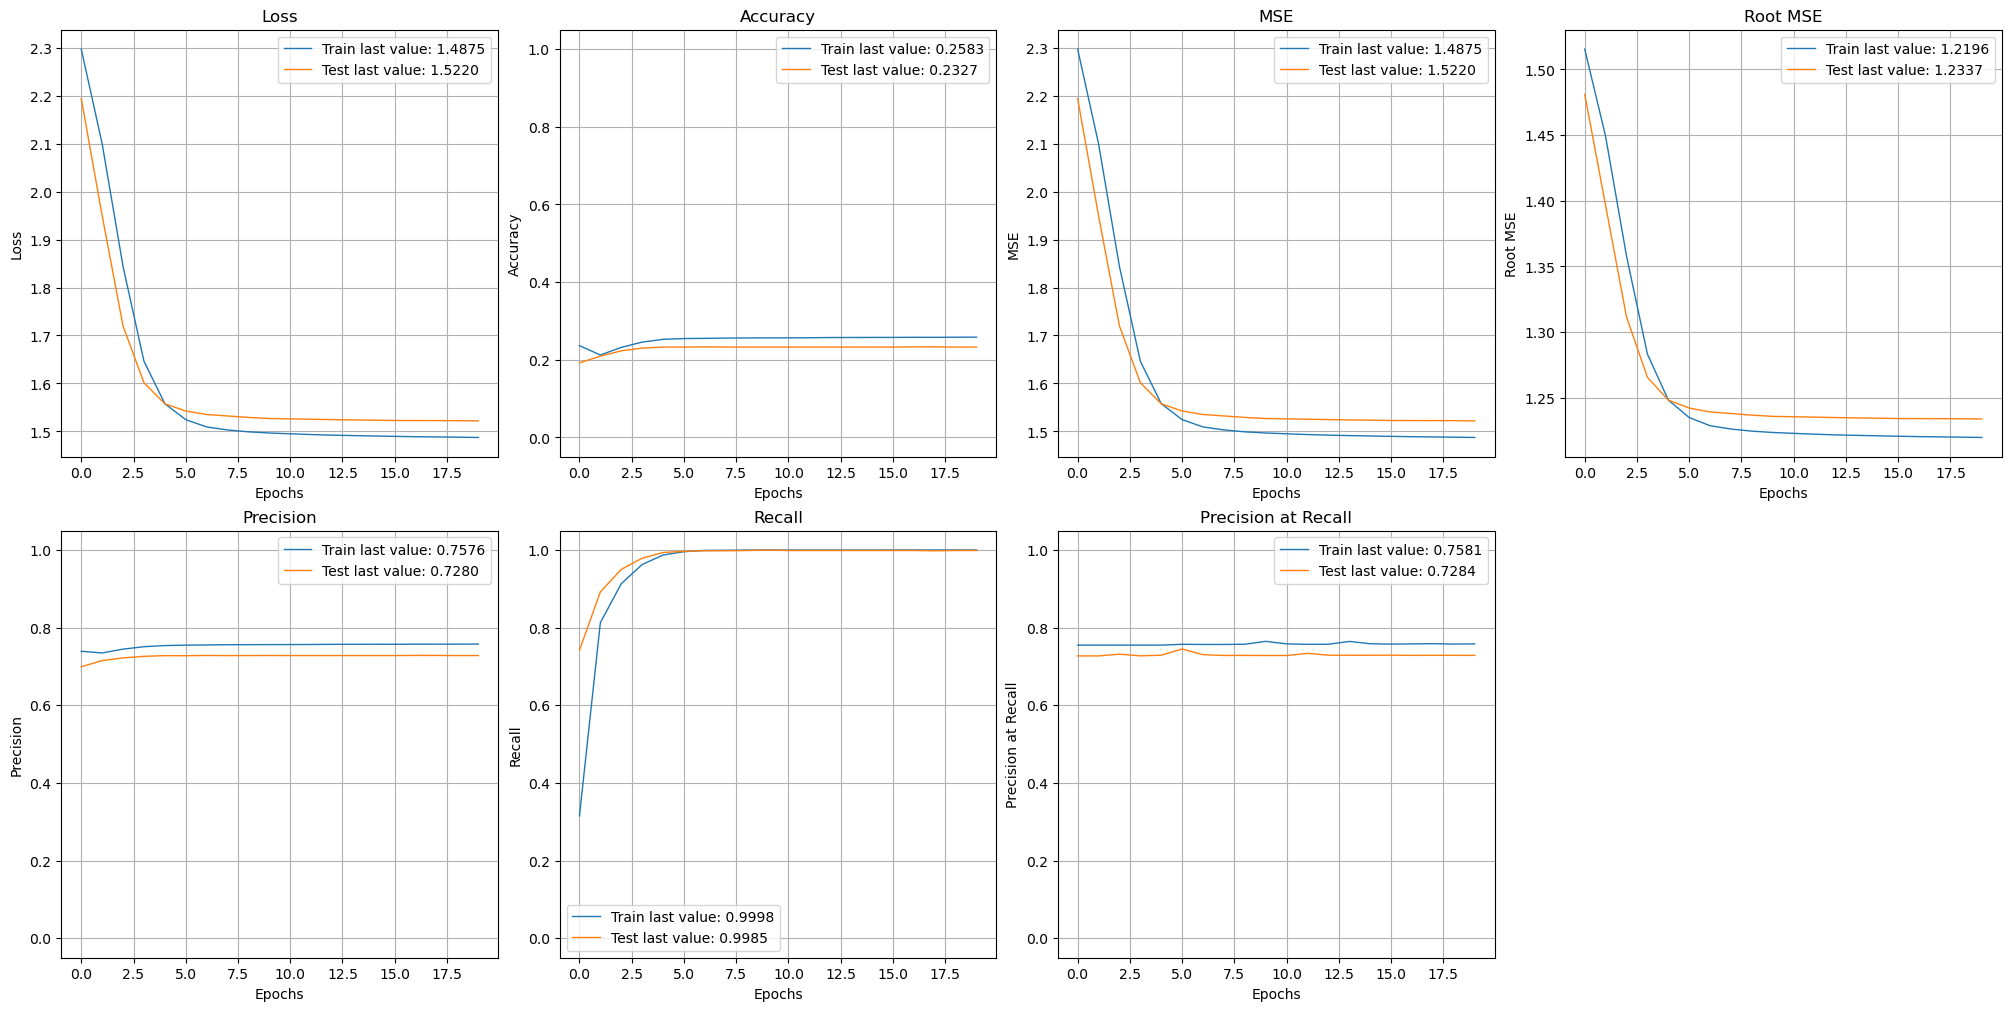

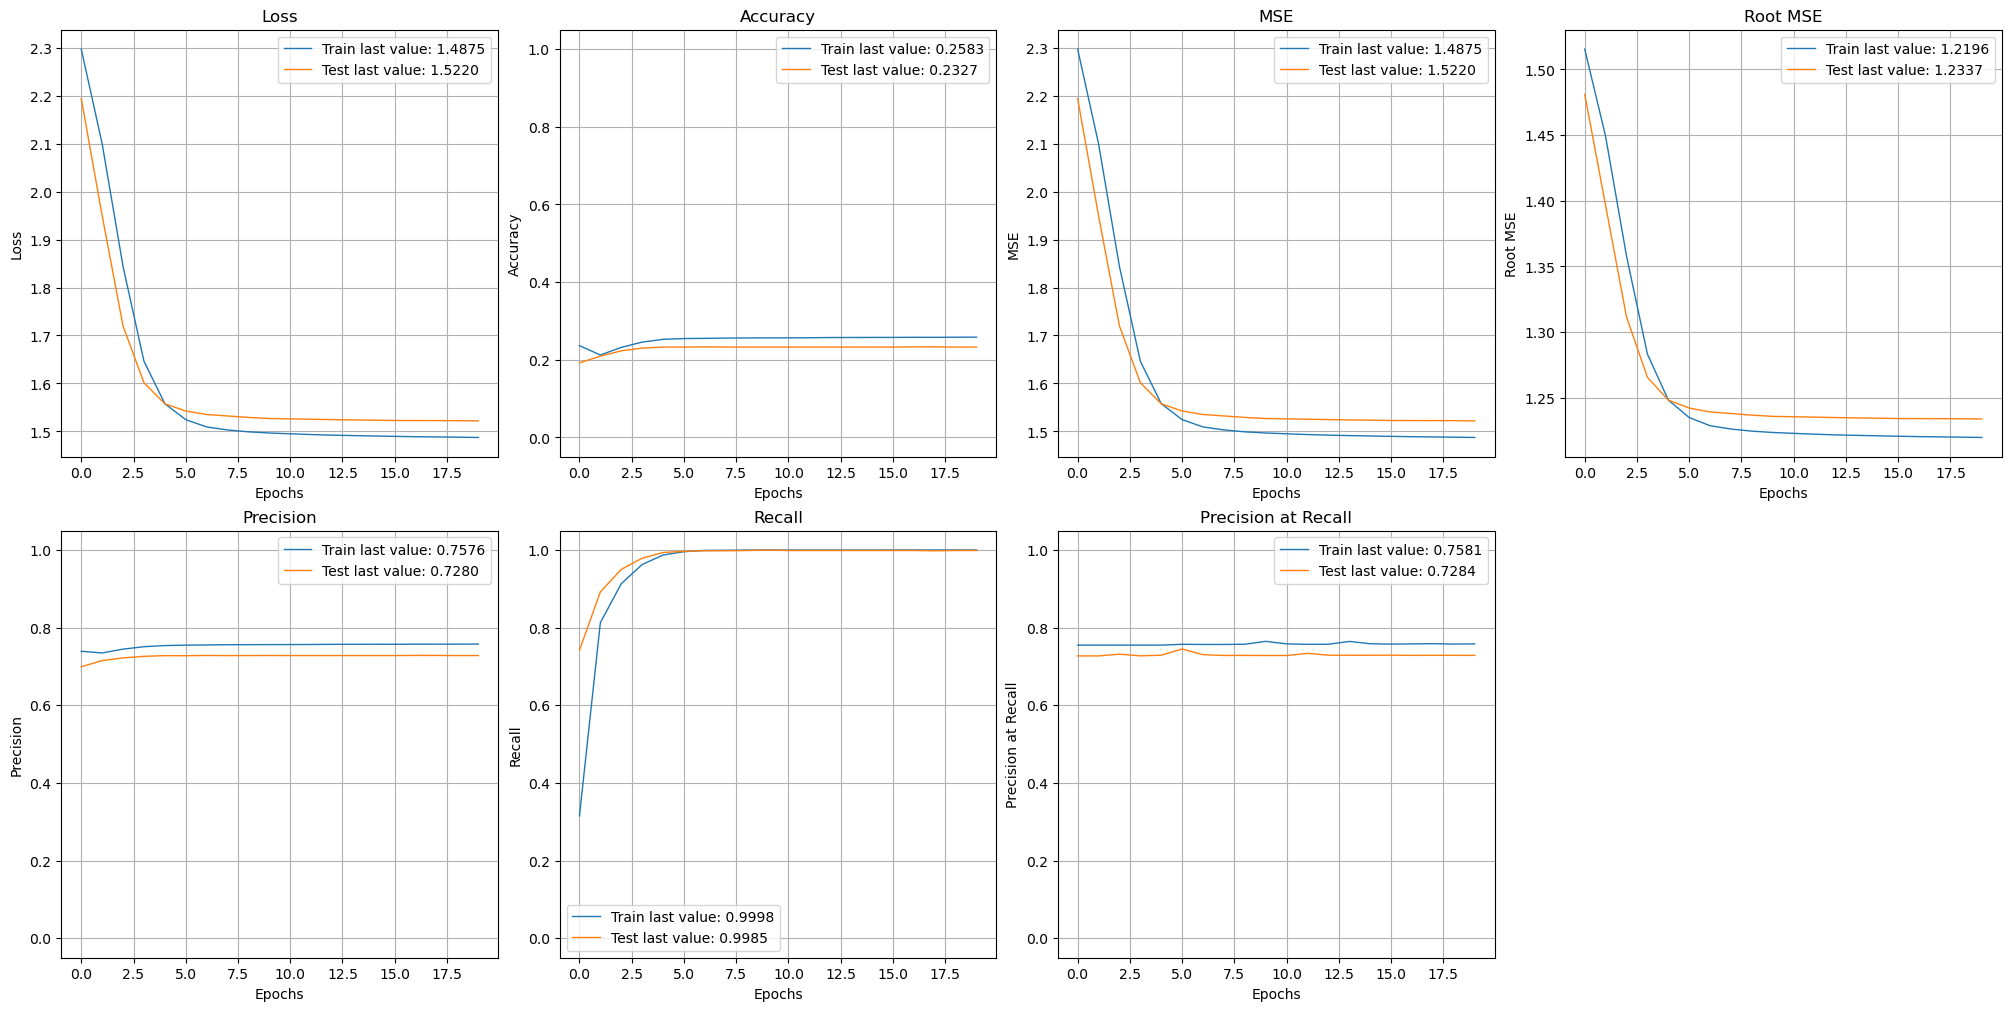

In [283]:
# list all data in history
print(history_emg_2.history.keys())

path_his_emg = "History_EMG_2_Retrain_" + str(epochs_emg_retrain) + "epochs_FINAL.png"

# summarize history for accuracy
show_history(history_emg_2)
plot_history(history_emg_2)
plot_history(history_emg_2, path=path_his_emg)
plt.close()

In [284]:
#Evaluate's EMG model for train dataset

score_retrain_emg_2 = model_lstm_emg_2.evaluate(x = X_train_emg_2_freq, 
                                            y = y_train_emg, 
                                            batch_size = emg_train_batch_size, 
                                            verbose = 2)

print("EMG Retrain Signal")
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[0].upper(), score_retrain_emg_2[0]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[1].upper(), score_retrain_emg_2[1]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[2].upper(), score_retrain_emg_2[2]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[3].upper(), score_retrain_emg_2[3]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[4].upper(), score_retrain_emg_2[4]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[5].upper(), score_retrain_emg_2[5]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_2.metrics_names[6].upper(), score_retrain_emg_2[6]*100))

11/11 - 0s - loss: 1.4938 - accuracy: 0.2532 - mean_squared_error: 1.4938 - root_mean_squared_error: 1.2222 - precision_20: 0.7516 - recall_20: 0.9996 - precision_at_recall_20: 0.7518 - 131ms/epoch - 12ms/step
EMG Retrain Signal
Retrain LOSS: 149.3795%
Retrain ACCURACY: 25.3158%
Retrain MEAN_SQUARED_ERROR: 149.3795%
Retrain ROOT_MEAN_SQUARED_ERROR: 122.2209%
Retrain PRECISION_20: 75.1638%
Retrain RECALL_20: 99.9571%
Retrain PRECISION_AT_RECALL_20: 75.1775%


In [285]:
# Evaluate's EMG model for test dataset

score_retest_emg_2 = model_lstm_emg_2.evaluate(x = X_test_emg_2_freq, 
                                           y = y_test_emg, 
                                           batch_size = emg_test_batch_size, 
                                           verbose = 2)

print("EMG Retest Signal")
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[0].upper(), score_retest_emg_2[0]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[1].upper(), score_retest_emg_2[1]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[2].upper(), score_retest_emg_2[2]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[3].upper(), score_retest_emg_2[3]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[4].upper(), score_retest_emg_2[4]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[5].upper(), score_retest_emg_2[5]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_2.metrics_names[6].upper(), score_retest_emg_2[6]*100))

8/8 - 0s - loss: 1.5563 - accuracy: 0.2444 - mean_squared_error: 1.5563 - root_mean_squared_error: 1.2475 - precision_20: 0.7582 - recall_20: 0.9983 - precision_at_recall_20: 0.7583 - 67ms/epoch - 8ms/step
EMG Retest Signal
Retest LOSS: 155.6327%
Retest ACCURACY: 24.4435%
Retest MEAN_SQUARED_ERROR: 155.6327%
Retest ROOT_MEAN_SQUARED_ERROR: 124.7528%
Retest PRECISION_20: 75.8161%
Retest RECALL_20: 99.8303%
Retest PRECISION_AT_RECALL_20: 75.8280%


#### EMG3

In [286]:
epochs_emg_3 = 20

In [287]:
#Load json ECG G1 epoch model 
json_file = open("./model_weights/model_bl_lstm_ecg_g3_20features_" + str(epochs_emg_3) + "epochs_FINAL.json", "r") 
loaded_model_ecg_lstm_json = json_file.read()
json_file.close()

In [288]:
#Load saved weights to loaded ecg model
model_lstm_emg_3 = model_from_json(loaded_model_ecg_lstm_json)
model_lstm_emg_3.load_weights("./model_weights/model_bl_lstm_weights_ecg_g3_20features_" + 
                            str(epochs_emg_1) + "epochs_FINAL.h5")

In [289]:
model_lstm_emg_3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_63 (Bidirect  (None, 1, 80)             25920     
 ional)                                                          
                                                                 
 lstm_169 (LSTM)             (None, 1, 256)            345088    
                                                                 
 dropout_70 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_170 (LSTM)             (None, 1, 128)            197120    
                                                                 
 dropout_71 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_171 (LSTM)             (None, 1, 64)             49408     
                                                     

In [290]:
model_lstm_emg_3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                                 loss="mean_squared_error",
                                 metrics=["accuracy", 
                                          tf.keras.metrics.MeanSquaredError(), 
                                          tf.keras.metrics.RootMeanSquaredError(),
                                          tf.keras.metrics.Precision(),
                                          tf.keras.metrics.Recall(),
                                          tf.keras.metrics.PrecisionAtRecall(0.5)])

In [291]:
#Evaluating without Retrain

score_evaluate_emg_3 = model_lstm_emg_3.evaluate(x = X_train_emg_3_freq, 
                                             y = y_train_emg, 
                                             batch_size = emg_train_batch_size, 
                                             verbose = 3)

print("TL's ECG to EMG Evaluate Result without Retrain")

print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[0].upper(), score_evaluate_emg_3[0]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[1].upper(), score_evaluate_emg_3[1]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[2].upper(), score_evaluate_emg_3[2]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[3].upper(), score_evaluate_emg_3[3]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[4].upper(), score_evaluate_emg_3[4]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[5].upper(), score_evaluate_emg_3[5]*100))
print("Evaluate without Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[6].upper(), score_evaluate_emg_3[6]*100))

TL's ECG to EMG Evaluate Result without Retrain
Evaluate without Retrain LOSS: 234.7802%
Evaluate without Retrain ACCURACY: 24.1276%
Evaluate without Retrain MEAN_SQUARED_ERROR: 234.7802%
Evaluate without Retrain ROOT_MEAN_SQUARED_ERROR: 153.2254%
Evaluate without Retrain PRECISION_21: 70.3597%
Evaluate without Retrain RECALL_21: 13.9714%
Evaluate without Retrain PRECISION_AT_RECALL_21: 74.9304%


In [292]:
score_evaluate_test_emg_3 = model_lstm_emg_3.evaluate(x = X_test_emg_3_freq, 
                                                  y = y_test_emg, 
                                                  batch_size = emg_test_batch_size, 
                                                  verbose = 3)

print("TL's ECG to EMG Evaluate Test Result without Retrain")
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[0].upper(), score_evaluate_test_emg_3[0]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[1].upper(), score_evaluate_test_emg_3[1]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[2].upper(), score_evaluate_test_emg_3[2]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[3].upper(), score_evaluate_test_emg_3[3]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[4].upper(), score_evaluate_test_emg_3[4]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[5].upper(), score_evaluate_test_emg_3[5]*100))
print("Test %s: %.4f%%" % (model_lstm_emg_3.metrics_names[6].upper(), score_evaluate_test_emg_3[6]*100))

TL's ECG to EMG Evaluate Test Result without Retrain
Test LOSS: 245.2505%
Test ACCURACY: 23.3733%
Test MEAN_SQUARED_ERROR: 245.2505%
Test ROOT_MEAN_SQUARED_ERROR: 156.6048%
Test PRECISION_21: 69.6275%
Test RECALL_21: 13.7443%
Test PRECISION_AT_RECALL_21: 75.6849%


In [293]:
#Train ECG Model to calibrate the parameters
# suffle = False - dont allow mix the data 
history_emg_3 = model_lstm_emg_3.fit(X_train_emg_3_freq, 
                                 y_train_emg, 
                                 validation_split=0.3, 
                                 epochs=epochs_emg_retrain, 
                                 batch_size=emg_train_batch_size, 
                                 shuffle=False)

Epoch 1/20
8/8 [==============================] - 7s 43ms/step - loss: 2.2896 - accuracy: 0.2484 - mean_squared_error: 2.2896 - root_mean_squared_error: 1.5132 - precision_21: 0.7409 - recall_21: 0.3846 - precision_at_recall_21: 0.7562 - val_loss: 2.2276 - val_accuracy: 0.2426 - val_mean_squared_error: 2.2276 - val_root_mean_squared_error: 1.4925 - val_precision_21: 0.7261 - val_recall_21: 0.7328 - val_precision_at_recall_21: 0.7331
Epoch 2/20
8/8 [==============================] - 0s 44ms/step - loss: 2.1513 - accuracy: 0.2560 - mean_squared_error: 2.1513 - root_mean_squared_error: 1.4667 - precision_21: 0.7558 - recall_21: 0.8224 - precision_at_recall_21: 0.7575 - val_loss: 2.0814 - val_accuracy: 0.2340 - val_mean_squared_error: 2.0814 - val_root_mean_squared_error: 1.4427 - val_precision_21: 0.7267 - val_recall_21: 0.8861 - val_precision_at_recall_21: 0.7331
Epoch 3/20
8/8 [==============================] - 0s 44ms/step - loss: 1.9967 - accuracy: 0.2531 - mean_squared_error: 1.9967 

Epoch 20/20
8/8 [==============================] - 0s 48ms/step - loss: 1.4905 - accuracy: 0.2643 - mean_squared_error: 1.4905 - root_mean_squared_error: 1.2209 - precision_21: 0.7634 - recall_21: 0.9978 - precision_at_recall_21: 0.7646 - val_loss: 1.5351 - val_accuracy: 0.2433 - val_mean_squared_error: 1.5351 - val_root_mean_squared_error: 1.2390 - val_precision_21: 0.7364 - val_recall_21: 0.9937 - val_precision_at_recall_21: 0.7377


dict_keys(['loss', 'accuracy', 'mean_squared_error', 'root_mean_squared_error', 'precision_21', 'recall_21', 'precision_at_recall_21', 'val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_precision_21', 'val_recall_21', 'val_precision_at_recall_21'])


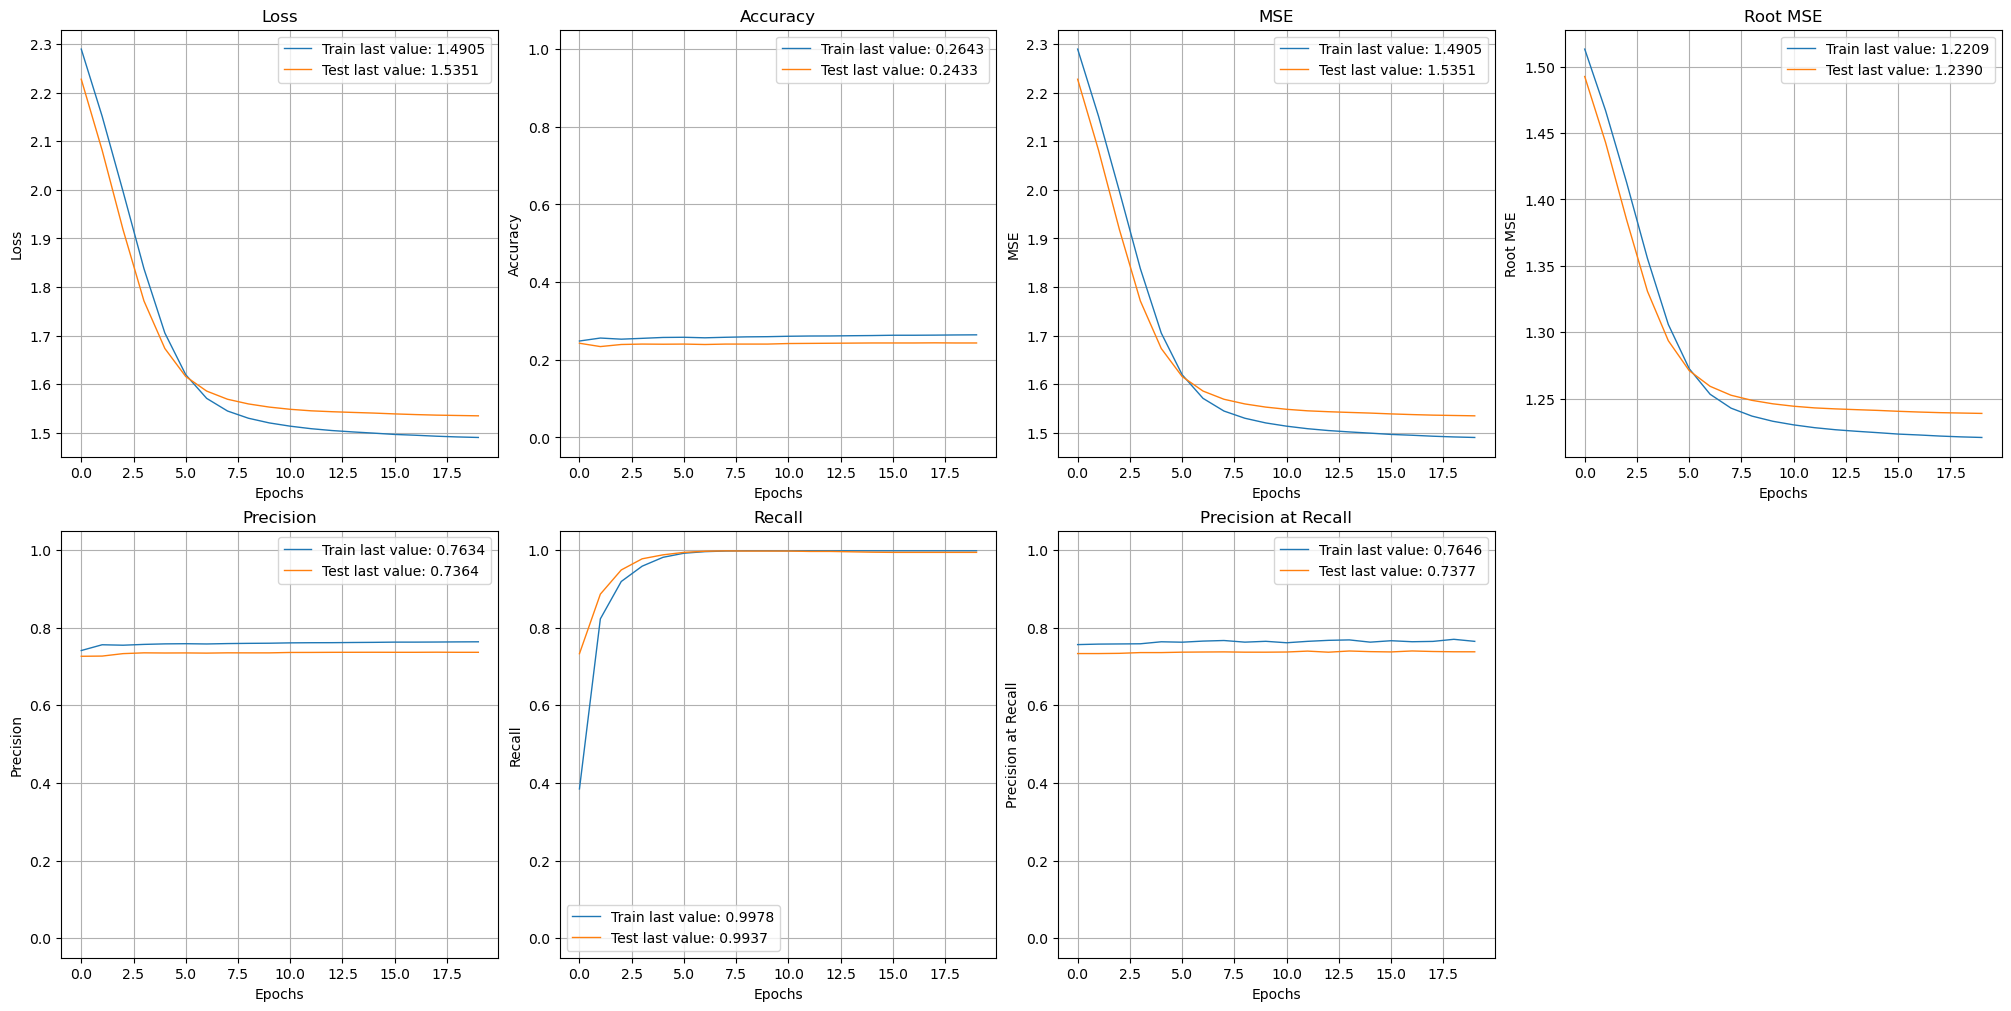

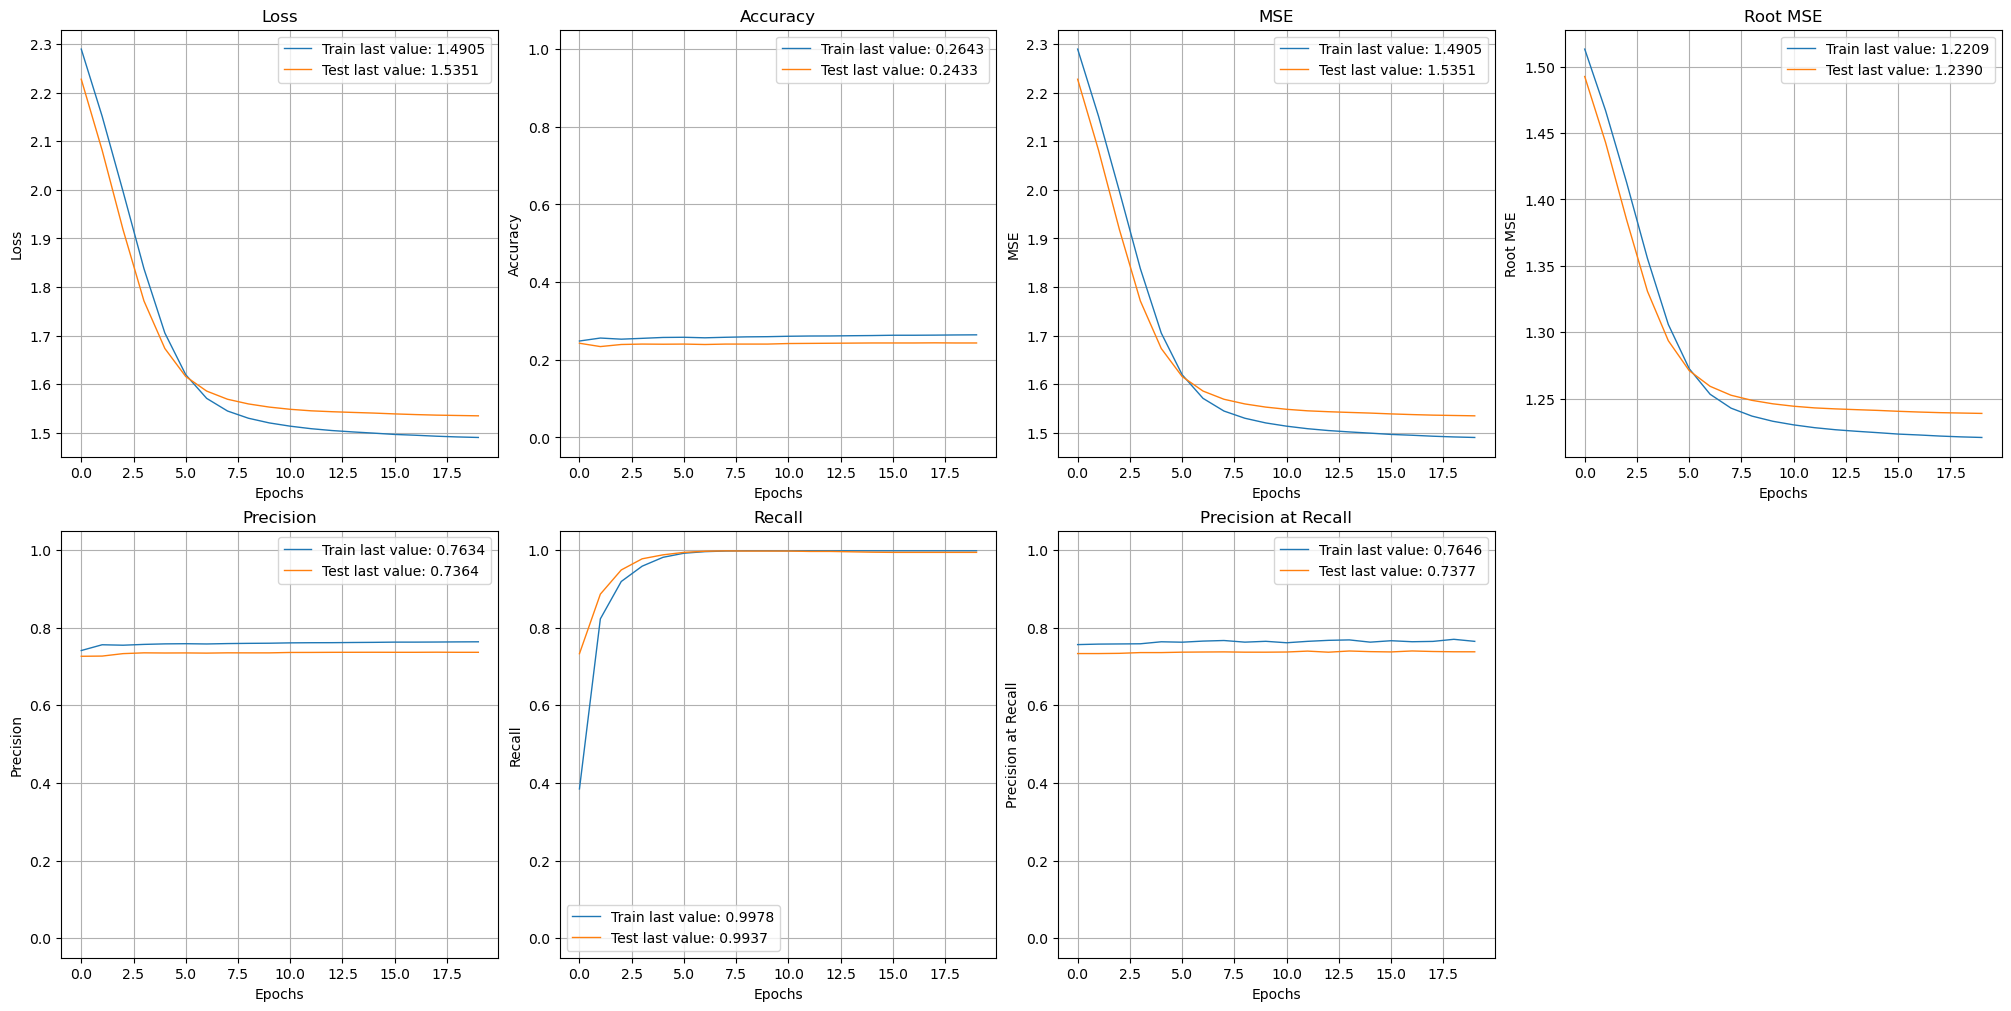

In [294]:
# list all data in history
print(history_emg_3.history.keys())

path_his_emg = "History_EMG_3_Retrain_" + str(epochs_emg_retrain) + "epochs_FINAL.png"

# summarize history for accuracy
show_history(history_emg_3)
plot_history(history_emg_3)
plot_history(history_emg_3, path=path_his_emg)
plt.close()

In [295]:
#Evaluate's EMG model for train dataset

score_retrain_emg_3 = model_lstm_emg_3.evaluate(x = X_train_emg_3_freq, 
                                            y = y_train_emg, 
                                            batch_size = emg_train_batch_size, 
                                            verbose = 3)

print("EMG Retrain Signal")
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[0].upper(), score_retrain_emg_3[0]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[1].upper(), score_retrain_emg_3[1]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[2].upper(), score_retrain_emg_3[2]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[3].upper(), score_retrain_emg_3[3]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[4].upper(), score_retrain_emg_3[4]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[5].upper(), score_retrain_emg_3[5]*100))
print("Retrain %s: %.4f%%" % (model_lstm_emg_3.metrics_names[6].upper(), score_retrain_emg_3[6]*100))

EMG Retrain Signal
Retrain LOSS: 150.2622%
Retrain ACCURACY: 25.8082%
Retrain MEAN_SQUARED_ERROR: 150.2622%
Retrain ROOT_MEAN_SQUARED_ERROR: 122.5815%
Retrain PRECISION_21: 75.5387%
Retrain RECALL_21: 99.6571%
Retrain PRECISION_AT_RECALL_21: 75.6451%


In [296]:
# Evaluate's EMG model for test dataset

score_retest_emg_3 = model_lstm_emg_3.evaluate(x = X_test_emg_3_freq, 
                                           y = y_test_emg, 
                                           batch_size = emg_test_batch_size, 
                                           verbose = 3)

print("EMG Retest Signal")
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[0].upper(), score_retest_emg_3[0]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[1].upper(), score_retest_emg_3[1]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[2].upper(), score_retest_emg_3[2]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[3].upper(), score_retest_emg_3[3]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[4].upper(), score_retest_emg_3[4]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[5].upper(), score_retest_emg_3[5]*100))
print("Retest %s: %.4f%%" % (model_lstm_emg_3.metrics_names[6].upper(), score_retest_emg_3[6]*100))

EMG Retest Signal
Retest LOSS: 156.9646%
Retest ACCURACY: 24.6147%
Retest MEAN_SQUARED_ERROR: 156.9646%
Retest ROOT_MEAN_SQUARED_ERROR: 125.2855%
Retest PRECISION_21: 75.9275%
Retest RECALL_21: 99.5475%
Retest PRECISION_AT_RECALL_21: 76.1039%
